In [24]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from api_keys import client_id, client_secret
import matplotlib.pyplot as plt
import seaborn as sns
#from keywords import keywords

import pandas as pd
import re

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

In [4]:
# Get total number of episodes for the show

show_id = '4rOoJ6Egrf8K2IrywzwOMk'
podcast = sp.show(show_id=show_id, market='US')

total_episodes = podcast['total_episodes']

print(total_episodes)

2113


In [5]:
# Get data for all shows
showNum = 0
data = []
# Pagination for show requests
while showNum <= total_episodes:
    print("Current Show Count: ", showNum)
    result = sp.show_episodes(show_id=show_id, limit=50, offset=showNum, market='US')

    episodes = result['items']

    # Loop through the 50 episodes requested
    for episode in episodes:
        title = episode['name']
        description = episode['description']
        duration_ms = episode['duration_ms']
        release_date = episode['release_date']
        
        myEpisode = {
            'title' : title,
            'description' : description,
            'duration_ms' : duration_ms,
            'release_date' : release_date
        }
        
        data.append(myEpisode)
    showNum += 50

print(len(data))

Current Show Count:  0
Current Show Count:  50
Current Show Count:  100
Current Show Count:  150
Current Show Count:  200
Current Show Count:  250
Current Show Count:  300
Current Show Count:  350
Current Show Count:  400
Current Show Count:  450
Current Show Count:  500
Current Show Count:  550
Current Show Count:  600
Current Show Count:  650
Current Show Count:  700
Current Show Count:  750
Current Show Count:  800
Current Show Count:  850
Current Show Count:  900
Current Show Count:  950
Current Show Count:  1000
Current Show Count:  1050
Current Show Count:  1100
Current Show Count:  1150
Current Show Count:  1200
Current Show Count:  1250
Current Show Count:  1300
Current Show Count:  1350
Current Show Count:  1400
Current Show Count:  1450
Current Show Count:  1500
Current Show Count:  1550
Current Show Count:  1600
Current Show Count:  1650
Current Show Count:  1700
Current Show Count:  1750
Current Show Count:  1800
Current Show Count:  1850
Current Show Count:  1900
Current S

In [6]:
# Create DF from data
df = pd.DataFrame(data)
df.head()

,title,description,duration_ms,release_date
0,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",10369428,2023-04-13
1,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",10797097,2023-04-12
2,#1968 - Jason Everman,Jason Everman is a musician and military veter...,9347177,2023-04-11
3,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",9816340,2023-04-07
4,#1967 - Mike Vecchione,Mike Vecchione is a stand-up comic and actor. ...,9674281,2023-04-06


In [7]:
# Change MS column to Seconds
df['duration_ms'] = df['duration_ms'].apply(lambda x: float(x / 60000)).round(decimals=2)
df.head()

,title,description,duration_ms,release_date
0,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",172.82,2023-04-13
1,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",179.95,2023-04-12
2,#1968 - Jason Everman,Jason Everman is a musician and military veter...,155.79,2023-04-11
3,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",163.61,2023-04-07
4,#1967 - Mike Vecchione,Mike Vecchione is a stand-up comic and actor. ...,161.24,2023-04-06


In [8]:
# Rename Columns
df = df.rename(columns={'duration_ms' : 'duration_seconds'})

In [9]:
# Find guest in show
guests = []
for row in df['title']:
    guest = re.findall(r"[A-Z][a-z]+,?\s+(?:[A-Z][a-z]*\.?\s*)?[A-Z][a-z]+", row)
    if guest:
         guests.append(guest[0])
    else:
        guests.append(pd.NaT)
df['guest'] = guests
df.head()

# def extract_names(text):
#     names = re.findall(r"\b[A-Z][a-z]+\s[A-Z][a-z]+\b", text)
#     return ", ".join(names)

# # Apply the function to the 'description' column and create a new column 'names'
# df['guest'] = df['description'].apply(extract_names)

# print(df)

,title,description,duration_seconds,release_date,guest
0,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",172.82,2023-04-13,Bill Ottman
1,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",179.95,2023-04-12,Sam Tallent
2,#1968 - Jason Everman,Jason Everman is a musician and military veter...,155.79,2023-04-11,Jason Everman
3,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",163.61,2023-04-07,Cory Sandhagen
4,#1967 - Mike Vecchione,Mike Vecchione is a stand-up comic and actor. ...,161.24,2023-04-06,Mike Vecchione


In [10]:
df['guest'].count

<bound method Series.count of 0          Bill Ottman
1          Sam Tallent
2        Jason Everman
3       Cory Sandhagen
4       Mike Vecchione
             ...      
2107      John Heffron
2108      John Heffron
2109       Ari Shaffir
2110      Brian Redban
2111      Brian Redban
Name: guest, Length: 2112, dtype: object>

In [11]:
df.dropna()

,title,description,duration_ms,release_date,guest
0,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",172.82,2023-04-13,Bill Ottman
1,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",179.95,2023-04-12,Sam Tallent
2,#1968 - Jason Everman,Jason Everman is a musician and military veter...,155.79,2023-04-11,Jason Everman
3,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",163.61,2023-04-07,Cory Sandhagen
4,#1967 - Mike Vecchione,Mike Vecchione is a stand-up comic and actor. ...,161.24,2023-04-06,Mike Vecchione
...,...,...,...,...,...
2107,"#5 - John Heffron, Ari Shaffir (Part 1)","Joe sits down with John Heffron, and Ari Shaffir.",64.17,2010-01-21,John Heffron
2108,"#5 - John Heffron, Ari Shaffir (Part 2)","Joe sits down with John Heffron, and Ari Shaffir.",72.94,2010-01-21,John Heffron
2109,#3 - Ari Shaffir,Joe sits down with Ari Shaffir.,134.99,2010-01-06,Ari Shaffir
2110,#2 - Brian Redban,Joe sits down with Brian Redban.,152.11,2009-12-29,Brian Redban


In [11]:
keywords = [
    'comedian',
    'comic',
    "phd",
    'actor',
    'writer',
    'author',
    'ufc',
    'musician',
    'artist',
    'founder',
    'youtuber',
    'podcast',
    'ceo',
    'philanthropist',
    'singer/songwriter',
    'screenwriter',
    'scientist',
    'co-host',
    'journalist',
    'entrepreneur',
    'astrophysicist',
    'politician',
    'pilot'
]

In [17]:
# Initialize new columns
for keyword in keywords:
    df[keyword] = 0
    df[f"{keyword}_sub"] = 0

# Loop through the descriptions and populate the new columns
for idx, row in df.iterrows():
    description = row["description"].lower()
    keyword_count = {}

    for keyword in keywords:
        if keyword in description:
            keyword_count[keyword] = keyword_count.get(keyword, 0) + 1
            if keyword_count[keyword] == 1:
                df.at[idx, keyword] = 1
            elif keyword_count[keyword] == 2:
                df.at[idx, f"{keyword}_sub"] = 1


In [18]:
df.head(50)

,title,description,duration_seconds,release_date,guest,comedian,comedian_sub,comic,comic_sub,phd,...,journalist,journalist_sub,entrepreneur,entrepreneur_sub,astrophysicist,astrophysicist_sub,politician,politician_sub,pilot,pilot_sub
0,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",172.82,2023-04-13,Bill Ottman,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",179.95,2023-04-12,Sam Tallent,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,#1968 - Jason Everman,Jason Everman is a musician and military veter...,155.79,2023-04-11,Jason Everman,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",163.61,2023-04-07,Cory Sandhagen,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,#1967 - Mike Vecchione,Mike Vecchione is a stand-up comic and actor. ...,161.24,2023-04-06,Mike Vecchione,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,#1966 - Big Jay Oakerson & Ari Shaffir,"Big Jay Oakerson is a stand-up comic, on-air p...",202.04,2023-04-05,Big Jay Oakerson,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,#1965 - David Choe,"David Choe is an artist, entrepreneur, travele...",197.53,2023-04-04,David Choe,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7,#1964 - Rick Doblin,"Rick Doblin, Ph.D., is the Founder in 1986 and...",169.34,2023-03-31,Rick Doblin,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,#1963 - Michael Shellenberger,Michael Shellenberger is the best-selling auth...,168.16,2023-03-30,Michael Shellenberger,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,#1962 - Eddie Huang,"Eddie Huang is an author, chef, restaurateur, ...",199.58,2023-03-29,Eddie Huang,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


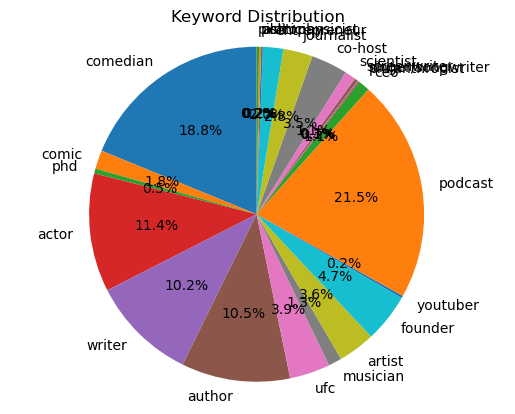

In [19]:
# Sum the values for each keyword and subcategory column
keyword_totals = {}
for keyword in keywords:
    keyword_totals[keyword] = df[keyword].sum()
    keyword_totals[f"{keyword}_sub"] = df[f"{keyword}_sub"].sum()

# Remove zero values
keyword_totals = {k: v for k, v in keyword_totals.items() if v > 0}

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(keyword_totals.values(), labels=keyword_totals.keys(), autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures the pie chart is circular
ax.axis('equal')

plt.title("Keyword Distribution")
plt.show()

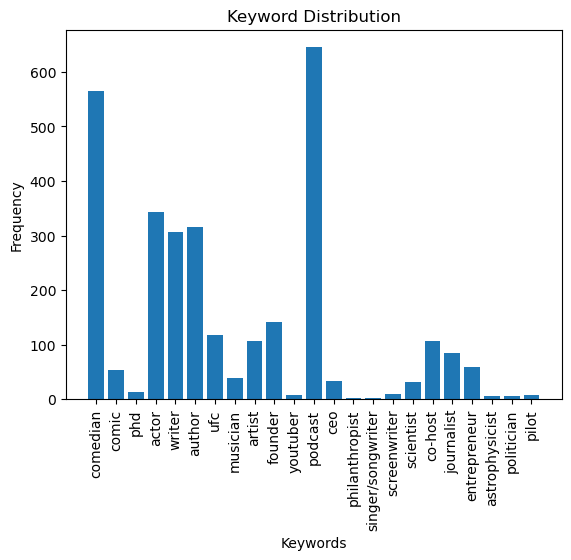

In [20]:
fig, ax = plt.subplots()
ax.bar(keyword_totals.keys(), keyword_totals.values())

plt.title("Keyword Distribution")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [22]:
category_runtimes = {}
for keyword in keywords:
    category_runtimes[keyword] = df.loc[df[keyword] == 1, "duration_seconds"].sum()
    category_runtimes[f"{keyword}_sub"] = df.loc[df[f"{keyword}_sub"] == 1, "duration_seconds"].sum()

# Remove zero values
category_runtimes = {k: v for k, v in category_runtimes.items() if v > 0}

print(category_runtimes)

{'comedian': 93083.44, 'comic': 9884.57, 'phd': 2217.5, 'actor': 55277.95, 'writer': 49644.97, 'author': 50473.03, 'ufc': 18003.939999999995, 'musician': 5815.03, 'artist': 17204.7, 'founder': 23021.659999999996, 'youtuber': 1110.23, 'podcast': 108807.95999999999, 'ceo': 5378.200000000001, 'philanthropist': 539.76, 'singer/songwriter': 605.78, 'screenwriter': 1299.98, 'scientist': 5461.95, 'co-host': 19464.8, 'journalist': 13353.249999999998, 'entrepreneur': 9230.04, 'astrophysicist': 831.67, 'politician': 731.19, 'pilot': 1098.45}


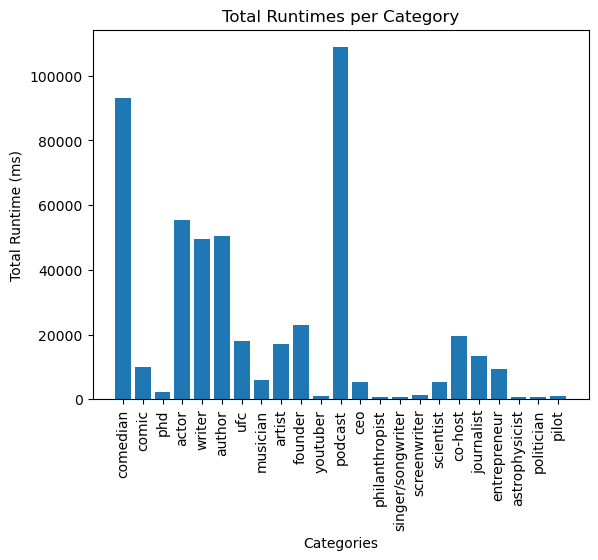

In [23]:
# Create the bar chart for total runtimes
fig, ax = plt.subplots()
ax.bar(category_runtimes.keys(), category_runtimes.values())

plt.title("Total Runtimes per Category")
plt.xlabel("Categories")
plt.ylabel("Total Runtime (ms)")
plt.xticks(rotation=90)
plt.show()

C:\Users\Steven\AppData\Local\Temp\ipykernel_13404\2347986242.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  category_duration_df = category_duration_df.append(keyword_df, ignore_index=True)
C:\Users\Steven\AppData\Local\Temp\ipykernel_13404\2347986242.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  category_duration_df = category_duration_df.append(sub_keyword_df, ignore_index=True)


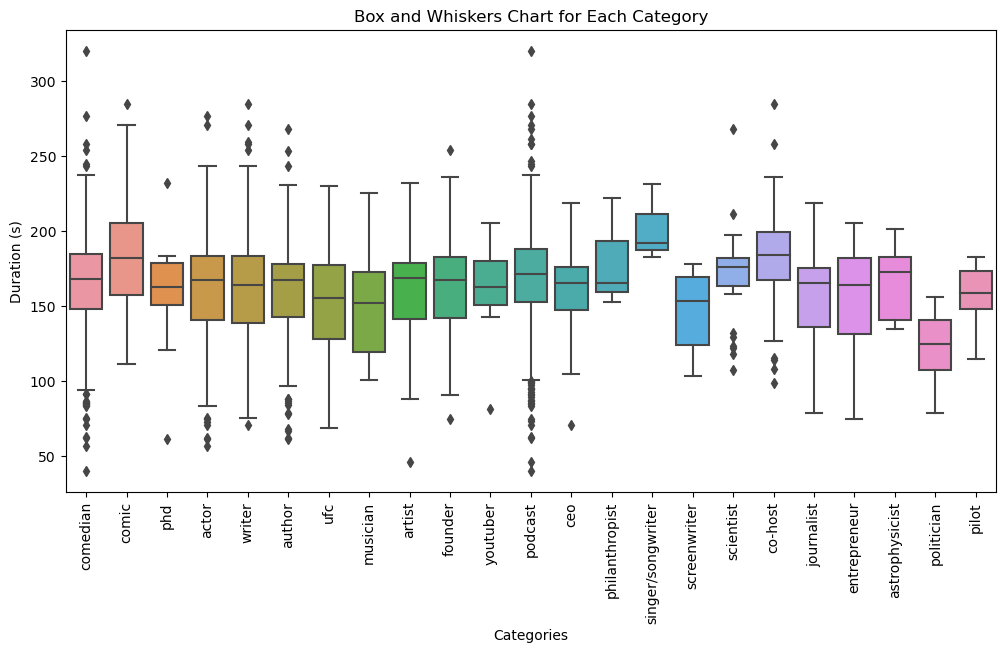

In [28]:
# Create a new DataFrame with only categories and durations
category_duration_df = pd.DataFrame(columns=["Category", "Duration"])

for keyword in keywords:
    keyword_data = df.loc[df[keyword] == 1, "duration_seconds"]
    keyword_df = pd.DataFrame({"Category": [keyword] * len(keyword_data), "Duration": keyword_data})
    category_duration_df = category_duration_df.append(keyword_df, ignore_index=True)
    
    sub_keyword = f"{keyword}_sub"
    sub_keyword_data = df.loc[df[sub_keyword] == 1, "duration_seconds"]
    sub_keyword_df = pd.DataFrame({"Category": [sub_keyword] * len(sub_keyword_data), "Duration": sub_keyword_data})
    category_duration_df = category_duration_df.append(sub_keyword_df, ignore_index=True)

# Remove categories with no data
category_duration_df = category_duration_df[category_duration_df["Duration"] > 0]

# Create the box and whiskers chart
plt.figure(figsize=(12, 6))
sns.boxplot(x="Category", y="Duration", data=category_duration_df)
plt.title("Box and Whiskers Chart for Each Category")
plt.xlabel("Categories")
plt.ylabel("Duration (s)")
plt.xticks(rotation=90)
plt.show()

In [14]:
df.head(50)


,title,description,duration_seconds,release_date,guest,comedian,comedian_sub,comic,comic_sub,phd,...,journalist,journalist_sub,entrepreneur,entrepreneur_sub,astrophysicist,astrophysicist_sub,politician,politician_sub,pilot,pilot_sub
0,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",172.82,2023-04-13,Bill Ottman,,,,,,...,,,,,,,,,,
1,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",179.95,2023-04-12,Sam Tallent,,,1,,,...,,,,,,,,,,
2,#1968 - Jason Everman,Jason Everman is a musician and military veter...,155.79,2023-04-11,Jason Everman,,,,,,...,,,,,,,,,,
3,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",163.61,2023-04-07,Cory Sandhagen,,,,,,...,,,,,,,,,,
4,#1967 - Mike Vecchione,Mike Vecchione is a stand-up comic and actor. ...,161.24,2023-04-06,Mike Vecchione,,,1,,,...,,,,,,,,,,
5,#1966 - Big Jay Oakerson & Ari Shaffir,"Big Jay Oakerson is a stand-up comic, on-air p...",202.04,2023-04-05,Big Jay Oakerson,,,1,,,...,,,,,,,,,,
6,#1965 - David Choe,"David Choe is an artist, entrepreneur, travele...",197.53,2023-04-04,David Choe,,,,,,...,,,1,,,,,,,
7,#1964 - Rick Doblin,"Rick Doblin, Ph.D., is the Founder in 1986 and...",169.34,2023-03-31,Rick Doblin,,,,,,...,,,,,,,,,,
8,#1963 - Michael Shellenberger,Michael Shellenberger is the best-selling auth...,168.16,2023-03-30,Michael Shellenberger,,,,,,...,1,,,,,,,,,
9,#1962 - Eddie Huang,"Eddie Huang is an author, chef, restaurateur, ...",199.58,2023-03-29,Eddie Huang,,,,,,...,,,,,,,,,,


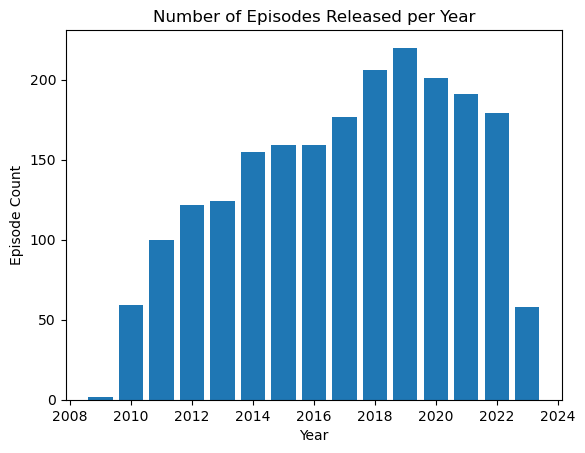

In [30]:
# Convert the release_date column to a datetime format
df['release_date'] = pd.to_datetime(df['release_date'])

# Extract the year from the release_date column
df['year'] = df['release_date'].dt.year

# Count the number of episodes per year
episodes_per_year = df['year'].value_counts().sort_index()

# Create a bar chart to visualize the episode count per year
plt.bar(episodes_per_year.index, episodes_per_year.values)
plt.title("Number of Episodes Released per Year")
plt.xlabel("Year")
plt.ylabel("Episode Count")
plt.show()

In [22]:
# # Split release date into seperate columns\n,
# df['release_date'] = df['release_date'].astype('datetime64[ns]')
# df['day'] = df['release_date'].map(lambda x: x.day)
# df['month'] = df['release_date'].map(lambda x: x.month)
# df['year'] = df['release_date'].map(lambda x: x.year)
# df.head()

/var/folders/2j/qtkc2d3d6ld7y6mhr39mt2_w0000gn/T/ipykernel_58627/2361380769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['release_date'] = df['release_date'].astype('datetime64[ns]')
/var/folders/2j/qtkc2d3d6ld7y6mhr39mt2_w0000gn/T/ipykernel_58627/2361380769.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['day'] = df['release_date'].map(lambda x: x.day)
/var/folders/2j/qtkc2d3d6ld7y6mhr39mt2_w0000gn/T/ipykernel_58627/2361380769.py:4: SettingWithCopyWarning: 
A value is trying to be set on a

,title,description,duration_ms,release_date,guest,category,day,month,year
0,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",172.82,2023-04-13,Bill Ottman,{founder},13,4,2023
1,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",179.95,2023-04-12,Sam Tallent,"{writer, actor, comic, podcast, author}",12,4,2023
2,#1968 - Jason Everman,Jason Everman is a musician and military veter...,155.79,2023-04-11,Jason Everman,{musician},11,4,2023
3,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",163.61,2023-04-07,Cory Sandhagen,{artist},7,4,2023
4,#1967 - Mike Vecchione,Mike Vecchione is a stand-up comic and actor. ...,161.24,2023-04-06,Mike Vecchione,"{actor, comic}",6,4,2023


# Use these cells if you already have CSV File

In [ ]:
# Pull Shows From CSV
df = pd.read_csv('data_files/podcast_data.csv')
df.head()

In [29]:
# Save to CSV To Reuse
df.to_csv('data_files/podcast_data.csv', index=False)

In [15]:
from keywords import keywordsList

ImportError: cannot import name 'keywordsList' from 'keywords' (/Users/hunter/Documents/GitHub/Wether_Men_Proj_1/keywords.py)

In [14]:
keywords = [
    'comedian',
    'comic',
    "phd",
    'actor',
    'writer',
    'author',
    'ufc',
    'musician',
    'artist',
    'founder',
    'youtuber',
    'podcast',
    'ceo',
    'philanthropist',
    'singer/songwriter',
    'screenwriter',
    'scientist',
    'co-host',
    'journalist',
    'entrepreneur',
    'astrophysicist',
    'politician',
    'pilot'
]

In [15]:
dataset = []
for desc in df['description']:
    newDesc = desc.lower()
    newDesc = newDesc.replace(',', '')
    newDesc = newDesc.replace('.', '')
    split = set(newDesc.split())
    found = split.intersection(keywords) 
    if found:
        dataset.append(found)
    else:
        dataset.append(pd.NaT)
    
df['category'] = dataset
df.head()

,title,description,duration_seconds,release_date,names,guest,category
0,#1970 - Bill Ottman,"Bill Ottman is founder of Minds, an open sourc...",172.82,2023-04-13,"Bill Ottman, Attend Minds, Vulcan Gas",Bill Ottman,{founder}
1,#1969 - Sam Tallent,"Sam Tallent is a stand-up comic, writer, and a...",179.95,2023-04-12,"Sam Tallent, Chubby Behemoth",Sam Tallent,"{writer, actor, comic, author, podcast}"
2,#1968 - Jason Everman,Jason Everman is a musician and military veter...,155.79,2023-04-11,"Jason Everman, Army Ranger, Green Beret, Team ...",Jason Everman,{musician}
3,JRE MMA Show #138 with Cory Sandhagen,"Joe is joined by Cory Sandhagen, a professiona...",163.61,2023-04-07,Cory Sandhagen,Cory Sandhagen,{artist}
4,#1967 - Mike Vecchione,Mike Vecchione is a stand-up comic and actor. ...,161.24,2023-04-06,"Mike Vecchione, The Attractives",Mike Vecchione,"{actor, comic}"


In [19]:
# comedian_df = df[df['category'].apply(lambda x: 'comedian' in x)]
#df['category'] = df['category'].apply(lambda x: ', '.join(x))
def is_iterable(obj):
    try:
        iter(obj)
        return True
    except TypeError:
        return False

# Convert sets to comma-separated strings
df['category'] = df['category'].apply(lambda x: ', '.join(x) if is_iterable(x) else x)

#print(df)
#print(comedian_df)
comedian_df = df[df['category'].apply(lambda x: 'comedian' in x)]

print(comedian_df)

TypeError: argument of type 'NaTType' is not iterable

In [18]:
df = df.dropna()

In [19]:
df.tail()

,title,description,duration_ms,release_date,guest,category
1817,"#316 - Enson Inoue, Chuck Liddell",Enson Inoue is a Japanese-American mixed marti...,116.76,2013-01-22,Enson Inoue,"{artist, ufc}"
1818,"#317 - David Choe, Yoshi Obayashi","David Choe is an American painter, muralist, g...",139.11,2013-01-22,David Choe,"{comedian, podcast, artist}"
1826,#307 - Bryan Callen,"Bryan Callen is an actor, stand-up comedian, a...",161.48,2013-01-04,Bryan Callen,"{comedian, actor, podcast}"
1827,#306 - Christopher Ryan,"Christopher Ryan, Ph.D., is a psychologist, sp...",166.44,2013-01-03,Christopher Ryan,"{phd, author}"
1845,#286 - Daniele Bolelli,"Daniele Bolelli is an Italian author, martial ...",137.32,2012-11-19,Daniele Bolelli,"{author, artist}"


In [20]:
category_subsets = {
    'comedy'   : ['comedian', 'comic', 'stand-up'],
    'science'  : ['phd', 'astrophysicist', 'scientist'],
    'music'    : ['singer/songwriter', 'musician', 'artist'],
    'sports'   : ['ufc', 'nfl', 'mlb', 'nba', 'nhl'],
    'business' : ['founder', 'entrepreneur', 'ceo'],
    'movies'   : ['actor', 'screenwriter'],
    'writer'   : ['author', 'writer'],
}

catList = ['comedy', 'science', 'music', 'sports', 'business', 'movies', 'writer']

In [24]:
category_counts = {
    'comedy' : 0,
    'science' : 0,
    'music' : 0,
    'sports' : 0,
    'business' : 0,
    'movies' : 0,
    'writer' : 0
}


for myList in df['category']:
    for cat in myList:
        for mainCat in catList:
            if cat in category_subsets[mainCat]:
                category_counts[mainCat] += 1
    
    
print(category_counts)

{'comedy': 577, 'science': 61, 'music': 144, 'sports': 96, 'business': 184, 'movies': 322, 'writer': 525}
